<a href="https://colab.research.google.com/github/nikiska77/ydata-viz-ai/blob/main/NN_sharing_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install packages

In [118]:

!pip install wget
!pip install -U git+https://github.com/pydicom/pydicom.git
#pip install --no-cache-dir git+https://github.com/pydicom/pydicom.git
!pip install python-gdcm

!pip install torchsummary 



In [29]:
import dicom_utils as dcm
import Affine3D as affine

In [ ]:
#input_file = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/YdataDataset.txt" 
#data_path = "/Users/boriskefer/Documents/coding/YDATA/2021_2022_main/viz_ai/ydata-viz-ai/data03_01"

In [31]:
#to work from Colab and google disk:
from google.colab import drive 
from pathlib import Path
import os

drive.mount('/content/drive')

home_path = Path("/content/drive/MyDrive/VIZ/data/data03_01")
#data_path = os.path.join(home_path, "data")
#print(data_path)

/content/drive/MyDrive/VIZ/data/data03_01/data


In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid

#Model

In [ ]:
x = torch.rand(1,3,64,64) # input x
y = torch.rand(1,3,64,64) # input y
cnn = nn.Conv2d(3,10,kernel_size=5) # network
input = torch.cat((x,y),dim=0) # stack them batch-wise
output = cnn(input) # pass both x and y through the network as a single pass
x_out = output[0] # get the output of x
y_out = output[1] # get the output of y

### Variant 1 (concatenating the input)

In [212]:
class Our_AirNet(nn.Module):
    def __init__(self):
        super(Our_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.firstlayer = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #(320 - 2)/2 + 1 = 160
        self.transition = nn.Sequential(
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),
            #(160 - 1 )/1 + 1 
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))
            #80
        self.regression = nn.Sequential(
            #we have to double here because the images will be concatenated
            nn.Linear(20*20*20*2, 1024),
            #nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
           # nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
           # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
           # nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 12))    
        
    def forward(self, x, y):
        inp = torch.cat((x,y),dim=0) # stack them batch-wise
        inp = self.firstlayer(inp)
        inp = self.transition(inp) #80
        inp = self.transition(inp) #40
        inp = self.transition(inp) #20
        input_conc = torch.cat((inp[:x.shape[0]],inp[x.shape[0]:]),dim=1)
        input_conc = self.flatten(input_conc)
        res = self.regression(input_conc)
        return res        



'\n        self.transition2 = nn.Sequential(\n            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),\n            #(80 - 1 )/1 + 1 \n            nn.BatchNorm2d(20),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))\n        #40\n        self.transition3 = nn.Sequential(\n            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=1,stride=1,padding=0),\n            #(40 - 1 )/1 + 1 \n            nn.BatchNorm2d(20),            \n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))\n            #20\n'

In [135]:
model = Our_AirNet()
summary(model, (20, 320, 320), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 20, 320, 320]           3,620
              ReLU-2          [1, 20, 320, 320]               0
         MaxPool2d-3          [1, 20, 160, 160]               0
            Conv2d-4          [1, 20, 160, 160]             420
       BatchNorm2d-5          [1, 20, 160, 160]              40
              ReLU-6          [1, 20, 160, 160]               0
         MaxPool2d-7            [1, 20, 80, 80]               0
            Conv2d-8            [1, 20, 80, 80]             420
       BatchNorm2d-9            [1, 20, 80, 80]              40
             ReLU-10            [1, 20, 80, 80]               0
        MaxPool2d-11            [1, 20, 40, 40]               0
           Conv2d-12            [1, 20, 40, 40]             420
      BatchNorm2d-13            [1, 20, 40, 40]              40
             ReLU-14            [1, 20,

In [113]:
a = torch.rand(1,3,5,5) # input a
#print(a)
b = torch.rand(1,3,5,5) # input b
#print(b)
c = torch.cat((a,b),dim=0) # stack them batch-wise
n=a.shape[0]
c.shape
d = torch.cat((c[:a.shape[0]],c[a.shape[0]:]),dim=1)
d.shape
#print(input_conc)
c[:a.shape[0]].shape

torch.Size([1, 3, 5, 5])

In [192]:
def normalize(img, min_val, max_val):
    return (img - min_val) / (max_val - min_val)

def transform(img):
    alpha = np.random.randint(-45, 45)
    m = affine.Affine3dRotateCenterMatrix(alpha, img.shape, axis=2)
    return affine.affine_transform(img, m), m

class Img3dDataSet(Dataset):
    def __init__(self, data_path, min_val, max_val):
        self.d_path = data_path
        self.min_val = min_val
        self.max_val = max_val
        self.transform = None
        self.target_transform = None
        names = [f for f in os.listdir(data_path) if f.endswith(".npz")]
        self.names_array = np.sort(np.array(names))
        
    def __getitem__(self, idx):
        name = self.names_array[idx]
        img3d = np.load(os.path.join(self.d_path, name))['I']
        img3d = normalize(img3d, self.min_val, self.max_val)
        label, matrix = transform(img3d)
        matrix = matrix[:3,:]
        print(matrix)
        label = label.transpose(2, 0, 1)
        label = torch.from_numpy(label).float()
        #adding this to get the dimensions nedded
        img3d = img3d.transpose(2, 0, 1)
        #print(img3d.shape , label.shape)
        item = torch.from_numpy(img3d).float()
        return item, label, matrix
    
    def __len__(self):
        return len(self.names_array)

In [193]:
dataset = Img3dDataSet(home_path, -1000, 1000)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [194]:
%%time
x, y, matrix = next(iter(dataloader))

[[  0.89879405   0.43837115   0.         -53.946434  ]
 [ -0.43837115   0.89879405   0.          86.33234   ]
 [  0.           0.           1.           0.        ]]
CPU times: user 937 ms, sys: 9.92 ms, total: 947 ms
Wall time: 1.08 s


In [186]:
x.shape, y.shape, matrix.shape

tensor([[[  0.7880,  -0.6157,   0.0000, 132.4241],
         [  0.6157,   0.7880,   0.0000, -64.5876],
         [  0.0000,   0.0000,   1.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,   1.0000]]])

In [188]:
matrix1 = matrix[:,:3,:]

tensor([[[  0.7880,  -0.6157,   0.0000, 132.4241],
         [  0.6157,   0.7880,   0.0000, -64.5876],
         [  0.0000,   0.0000,   1.0000,   0.0000]]])

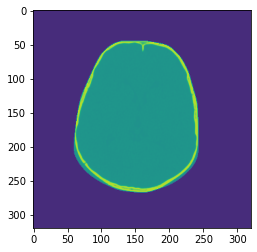

In [40]:
plt.imshow(x[0][:,:,10])

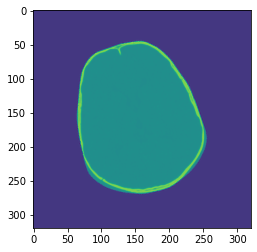

In [41]:
plt.imshow(y[0][:,:,10])

#Running model

In [208]:
model = Our_AirNet()
model.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 100

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 0
 Current loss 10338.82421875

Epoch number 1
 Current loss 5721.9111328125

Epoch number 2
 Current loss 37452.96875

Epoch number 3
 Current loss 2823.93115234375

Epoch number 4
 Current loss 7033.1787109375

Epoch number 5
 Current loss 7724.96484375

Epoch number 6
 Current loss 6364.59375

Epoch number 7
 Current loss 3148.37451171875

Epoch number 8
 Current loss 3017.333740234375

Epoch number 9
 Current loss 727.8994750976562

Epoch number 10
 Current loss 991.2214965820312

Epoch number 11
 Current loss 854.8193359375

Epoch number 12
 Current loss 295.2047119140625

Epoch number 13
 Current loss 326.9856262207031

Epoch number 14
 Current loss 347.97808837890625

Epoch number 15
 Current loss 297.1258239746094

Epoch number 16
 Current loss 209.65179443359375

Epoch number 17
 Current loss 185.85714721679688

Epoch number 18
 Current loss 149.67311096191406

Epoch number 19
 Current loss 49.76911544799805

Epoch number 20
 Current loss 67.02493286132812

Epoch 

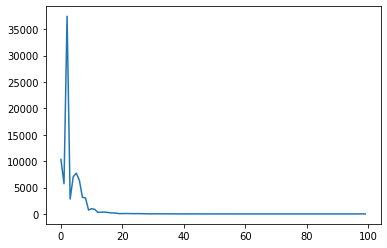

In [209]:
best_loss = np.inf
loss_history = [] 
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        res = model(x, y)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        if best_loss > loss:
          best_loss = loss
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        loss_history.append(loss.item())
print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
#y.shape

In [213]:
model2 = Our_AirNet()
model2.train()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model2.parameters(), lr = 0.005 )
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
num_epochs = 100

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([1, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch number 0
 Current loss 10353.98828125

Epoch number 1
 Current loss 6155.484375

Epoch number 2
 Current loss 11612.826171875

Epoch number 3
 Current loss 3658.551513671875

Epoch number 4
 Current loss 5924.97265625

Epoch number 5
 Current loss 4848.150390625

Epoch number 6
 Current loss 2007.4996337890625

Epoch number 7
 Current loss 3782.858642578125

Epoch number 8
 Current loss 430.45941162109375

Epoch number 9
 Current loss 1156.613037109375

Epoch number 10
 Current loss 946.2814331054688

Epoch number 11
 Current loss 227.49412536621094

Epoch number 12
 Current loss 1059.4522705078125

Epoch number 13
 Current loss 131.41661071777344

Epoch number 14
 Current loss 447.1605224609375

Epoch number 15
 Current loss 354.50177001953125

Epoch number 16
 Current loss 127.11165618896484

Epoch number 17
 Current loss 289.667724609375

Epoch number 18
 Current loss 222.00936889648438

Epoch number 19
 Current loss 66.95552062988281

Epoch number 20
 Current loss 156.8846893

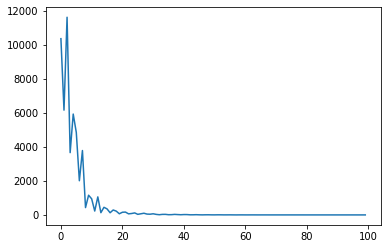

In [214]:
best_loss = np.inf
loss_history = [] 
#iteration_number= 0

# Iterate throught the epochs
for epoch in range(num_epochs):

    # Iterate over batches
#    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
 #       img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
  

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        res = model2(x, y)

        # Pass the outputs of the networks and label into the loss function
        loss = criterion(res, matrix.flatten())
        if best_loss > loss:
          best_loss = loss
        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        scheduler.step() 
        # Every 10 batches print out the loss
#        if i % 10 == 0 :
        print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
        #iteration_number += 10

        loss_history.append(loss.item())
print(f'Best loss {best_loss}')

plt.plot(range(num_epochs),loss_history)
plt.show()
#y.shape

In [93]:
x.shape

torch.Size([1, 20, 320, 320])

###Variant2 (Siamese network)

In [ ]:
class Siam_AirNet(nn.Module):
    def __init__(self):
        super(Siam_AirNet, self).__init__()
        self.flatten = nn.Flatten()
        self.features = nn.Sequential(
            #how many channels do we have?? 
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #(320 - 3 + 2*1)/1 + 1 = 320
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #(320 - 2)/2 + 1 = 160
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #160
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #80
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #80
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            #40
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            #20
            nn.Conv2d(in_channels=20,out_channels=20,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))

        self.regression = nn.Sequential(
            nn.Linear(20*20*20, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 1))            

    def forward(self, x, y):
        inp = torch.cat((x,y),dim=0) # stack them batch-wise
        inp = self.firstlayer(inp)
        inp = self.transition1(inp)
        inp = self.transition2(inp)
        inp = self.transition3(inp)
        inp = self.transition4(inp)
        input_conc = torch.cat((inp[:x.shape[0]],inp[x.shape[0]:]),dim=1)
        input_conc = self.flatten(input_conc)
        res = self.regression(input_conc)
        return res


    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input_t, input_ref):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        input_t = self.forward_once(input_t)
        input_ref = self.forward_once(input_ref)

        return input_t, input_ref

In [ ]:
x[:,:,:,10:11].shape

torch.Size([16, 320, 320, 1])

In [ ]:
batch = next(iter(dataloader))
batch.shape

torch.Size([16, 320, 320, 20])